---

# Q2 - Let's Solve the 4 Stage Distribution Problem

---

---

Let's solve this problem

---

In [3]:
from gurobipy import Model, GRB, quicksum

# Initialize the model
model = Model("4-Layer_Supply_Chain")

# Sets
suppliers = ["CHN", "AUS", "KAZ"]
plants = ["Austin", "Charlotte"]
distribution_centers = ["Houston", "NY", "LA"]
demand_regions = ["Asia Pacific", "Europe", "North America", "Middle East", "South America"]

# Maximum capacity of plants
max_dc_capacity = 30000  # Example capacity for distribution centers

# Cost for opening distribution centers
opening_cost = {
    "Houston": 1_500_000,
    "NY": 2_000_000,
    "LA": 1_800_000,
}

# Demand at each demand region
demand = {
    "Asia Pacific": 15_000,
    "Europe": 10_000,
    "North America": 8_000,
    "Middle East": 4_000,
    "South America": 3_000
}

# Costs for edges
cost_X = {
    ("CHN", "Austin"): 150,
    ("CHN", "Charlotte"): 160,
    ("AUS", "Austin"): 175,
    ("AUS", "Charlotte"): 170,
    ("KAZ", "Austin"): 165,
    ("KAZ", "Charlotte"): 180
}

cost_Y = {
    ("Austin", "Houston"): 20,
    ("Austin", "NY"): 100,
    ("Austin", "LA"): 70,
    ("Charlotte", "Houston"): 90,
    ("Charlotte", "NY"): 30,
    ("Charlotte", "LA"): 120,
}

cost_Z = {
    ("Houston", "Asia Pacific"): 220,
    ("Houston", "Europe"): 195,
    ("Houston", "North America"): 70,
    ("Houston", "Middle East"): 240,
    ("Houston", "South America"): 90,
    ("NY", "Asia Pacific"): 250,
    ("NY", "Europe"): 180,
    ("NY", "North America"): 75,
    ("NY", "Middle East"): 230,
    ("NY", "South America"): 115,
    ("LA", "Asia Pacific"): 200,
    ("LA", "Europe"): 210,
    ("LA", "North America"): 85,
    ("LA", "Middle East"): 235,
    ("LA", "South America"): 95
}

# Decision variables
X = model.addVars(suppliers, plants, name="Xij", vtype=GRB.CONTINUOUS)  # Flow from suppliers to plants
Y = model.addVars(plants, distribution_centers, name="Yjk", vtype=GRB.CONTINUOUS)  # Flow from plants to distribution
Z = model.addVars(distribution_centers, demand_regions, name="Zkl", vtype=GRB.CONTINUOUS)  # Flow from distribution to demand
U = model.addVars(distribution_centers, name="Uk", vtype=GRB.BINARY)  # Binary variable for distribution centers

model.setObjective(
    quicksum(cost_X[i, j] * X[i, j] for i in suppliers for j in plants) +
    quicksum(cost_Y[j, k] * Y[j, k] for j in plants for k in distribution_centers) +
    quicksum(cost_Z[k, l] * Z[k, l] for k in distribution_centers for l in demand_regions) +
    quicksum(opening_cost[k] * U[k] for k in distribution_centers),
    GRB.MINIMIZE
)

# Constraints
# 1. Flow conservation at plants (input = output)
for j in plants:
    model.addConstr(quicksum(X[i, j] for i in suppliers) == quicksum(Y[j, k] for k in distribution_centers), 
                    name=f"Plant_Balance_{j}")

# 2. Flow conservation at distribution centers (input = output)
for k in distribution_centers:
    model.addConstr(quicksum(Y[j, k] for j in plants) == quicksum(Z[k, l] for l in demand_regions) * U[k], 
                    name=f"Distribution_Balance_{k}")

# 3. Demand satisfaction at demand regions
for l in demand_regions:
    model.addConstr(quicksum(Z[k, l] for k in distribution_centers) == demand[l], 
                    name=f"Demand_Satisfaction_{l}")

# 4. Plant capacity constraints
for j in plants:
    model.addConstr(quicksum(X[i, j] for i in suppliers) <= max_dc_capacity, 
                    name=f"Plant_Capacity_{j}")

# 5. Distribution center capacity constraints
for k in distribution_centers:
    model.addConstr(quicksum(Z[k, l] for l in demand_regions) <= max_dc_capacity * U[k], 
                    name=f"Distribution_Capacity_{k}")

# Solve the model
model.optimize()

# Display results (optional)
if model.status == GRB.OPTIMAL:
    print("Optimal solution found!")
    for var in model.getVars():
        print(f"{var.varName}: {var.x}")
else:
    print("No optimal solution found.")


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 12 rows, 30 columns and 51 nonzeros
Model fingerprint: 0xe737273f
Model has 3 quadratic constraints
Variable types: 27 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [2e+01, 2e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+03, 3e+04]
Presolve removed 2 rows and 6 columns
Presolve time: 0.00s
Presolved: 55 rows, 81 columns, 177 nonzeros
Presolved model has 36 SOS constraint(s)
Variable types: 60 continuous, 21 integer (21 binary)
Found heuristic solution: objective 1.804000e+07
Found heuristic solution: objective 1.739000e+07

Root relaxation: objective 1.623167e+07, 19 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Curre

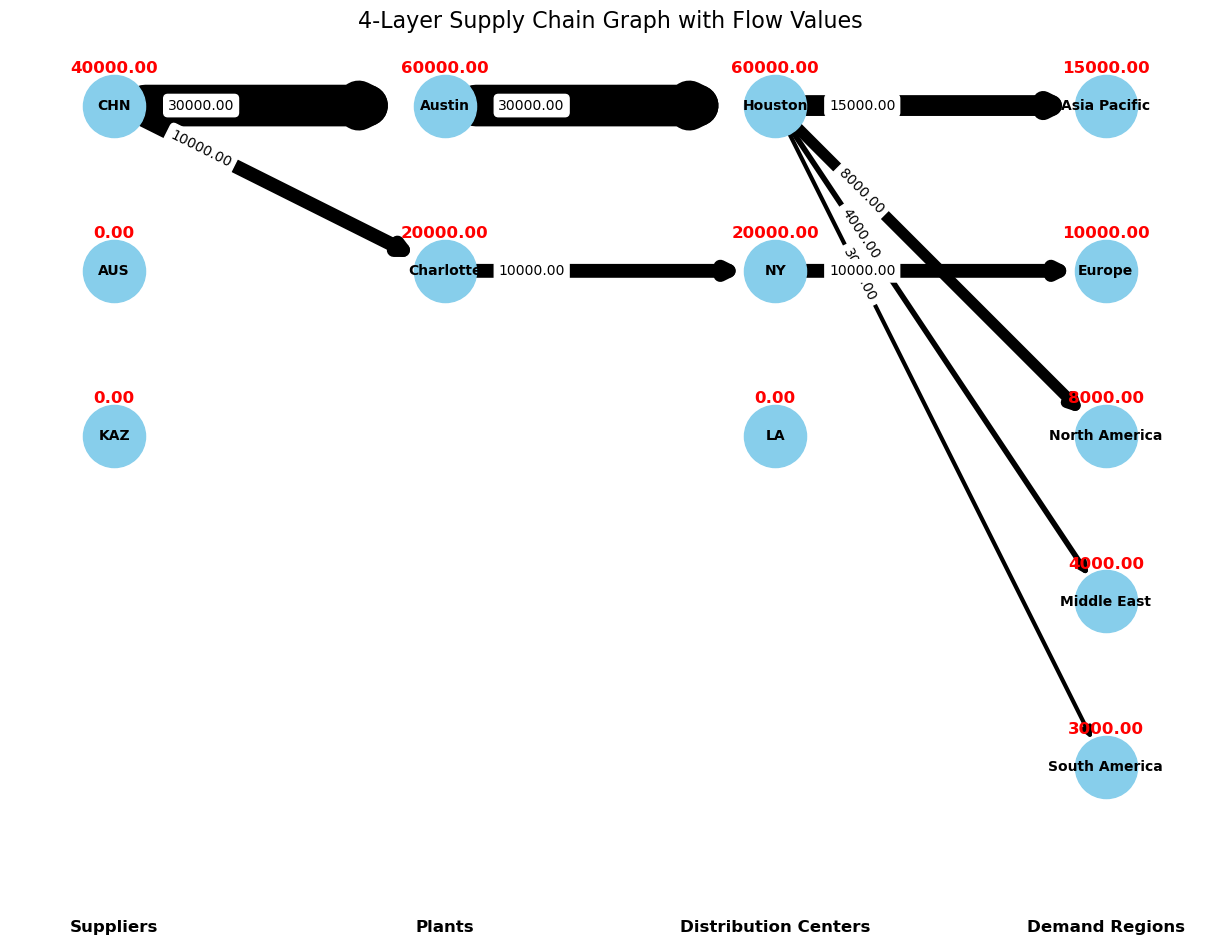

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

# Create the graph
G = nx.DiGraph()

# Add nodes to the graph with their layer as an attribute
for supplier in suppliers:
    G.add_node(supplier, layer=0)
for plant in plants:
    G.add_node(plant, layer=1)
for dc in distribution_centers:
    G.add_node(dc, layer=2)
for region in demand_regions:
    G.add_node(region, layer=3)

# Add edges between the layers with the solution values as labels
for (i, j), var in X.items():
    if var.x > 0:
        G.add_edge(i, j, weight=var.x)

for (j, k), var in Y.items():
    if var.x > 0:
        G.add_edge(j, k, weight=var.x)

for (k, l), var in Z.items():
    if var.x > 0:
        G.add_edge(k, l, weight=var.x)

# Position nodes by layer
pos = {}
layer_x = {0: 0, 1: 1, 2: 2, 3: 3}
for i, nodes in enumerate([suppliers, plants, distribution_centers, demand_regions]):
    y_positions = range(len(nodes))
    for j, node in enumerate(nodes):
        pos[node] = (layer_x[i], -j)

# Draw the graph
plt.figure(figsize=(12, 8))
edges = G.edges(data=True)
widths = [d['weight'] / 1000 for (u, v, d) in edges]  # Scale the width by dividing by 1000

nx.draw(
    G, pos,
    with_labels=True,
    node_color="skyblue",
    node_size=2000,
    font_size=10,
    font_weight="bold",
    arrowsize=15,
    width=widths
)

# Draw edge labels with increased font size and position them close to the departure node
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, label_pos=0.25)

# Calculate and display total flow through each node
node_flows = {node: 0 for node in G.nodes}
for (u, v, d) in G.edges(data=True):
    node_flows[u] += d['weight']
    node_flows[v] += d['weight']

# Display the flow values
for node, flow in node_flows.items():
    plt.text(pos[node][0], pos[node][1] + 0.2, f"{flow:.2f}", fontsize=12, fontweight="bold", color="red", ha='center')

plt.title("4-Layer Supply Chain Graph with Flow Values", fontsize=16)

# Add layer labels
layer_names = {0: "Suppliers", 1: "Plants", 2: "Distribution Centers", 3: "Demand Regions"}
for layer, x in layer_x.items():
    plt.text(x, -len(nodes), f"{layer_names[layer]}", fontsize=12, fontweight="bold", ha='center')

plt.show()
